In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

/home/ubuntu/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=(m, n)).astype('float32')

In [3]:
def weights_variable(shape):
    return tf.Variable(initial_value=tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [4]:
X = tf.placeholder(dtype=tf.float32, shape=[None, 784])

D_conv1_W = weights_variable([5, 5, 1, 64])
D_conv1_b = bias_variable([64])

D_conv2_W = weights_variable([5, 5, 64, 128])
D_conv2_b = bias_variable([128])

D_fc1_W = weights_variable([6272, 1024])
D_fc1_b = bias_variable([1024])

D_fc2_W = weights_variable([1024, 1])
D_fc2_b = bias_variable([1])

#thelta_D = [D_W1, D_b1, D_W2, D_b2]

Z = tf.placeholder(dtype=tf.float32, shape=[None, 100])

G_fc1_W = weights_variable([100, 1024])
G_fc1_b = bias_variable([1024])

G_fc2_W = weights_variable([1024, 6272])
G_fc2_b = bias_variable([6272])

G_conv1_W = weights_variable([5, 5, 128, 128])
G_conv1_b = bias_variable([128])

G_conv2_W = weights_variable([5, 5, 128, 64])
G_conv2_b = bias_variable([64])

G_conv3_W = weights_variable([5, 5, 64, 64])
G_conv3_b = bias_variable([64])

G_conv4_W = weights_variable([5, 5, 64, 1])
G_conv4_b = bias_variable([1])

#thelta_G = [G_fc1_W, G_fc1_b, G_fc2_W, G_fc2_b, G_conv1_W, G_conv1_b, G_conv2_W, G_conv2_b, G_conv3_W, G_conv3_b, G_conv4_W, G_conv4_b]

In [5]:
def discriminator(x):
    # CONV1 28*28*1 -> CONV2 28*28*64 -> POOL2 14*14*64 -> CONV3 14*14*128 -> POOL3 7*7*128 -> FC1 1024 -> FC2 1
    x_plus = tf.reshape(x, [-1, 28, 28, 1])
    D_conv1_h = tf.nn.relu(conv2d(x_plus, D_conv1_W) + D_conv1_b)
    D_conv1_pool = max_pool_2(D_conv1_h)
    D_conv2_h = tf.nn.relu(conv2d(D_conv1_pool, D_conv2_W) + D_conv2_b)
    D_conv2_pool = max_pool_2(D_conv2_h)
    
    D_fc1_in = tf.reshape(D_conv2_pool, [-1, 7*7*128])
    D_fc1_h = tf.nn.relu(tf.matmul(D_fc1_in, D_fc1_W) + D_fc1_b)
    D_prob_logit = tf.matmul(D_fc1_h, D_fc2_W) + D_fc2_b
    D_prob = tf.nn.relu(D_prob_logit)
    return D_prob, D_prob_logit

In [6]:
def generator(z):
    # FC1 100 -> FC2 1024 -> FC3 6272 -> 7*7*128 -> CONV1 14*14*128 -> CONV2 14*14*64 -> conv3 28*28*64 -> conv4 28*28*1
    G_fc1_h = tf.nn.relu(tf.matmul(z, G_fc1_W) + G_fc1_b)
    G_fc2_h = tf.nn.relu(tf.matmul(G_fc1_h, G_fc2_W) + G_fc2_b)
    G_fc2_h_plus = tf.reshape(G_fc2_h, [-1, 7, 7, 128])
    G_conv1_h = tf.layers.conv2d_transpose(G_fc2_h_plus, 128, kernel_size=5, strides=2, padding='same', activation=tf.nn.relu)
    G_conv2_h = tf.nn.relu(conv2d(G_conv1_h, G_conv2_W) + G_conv2_b)
    G_conv3_h = tf.layers.conv2d_transpose(G_conv2_h, 64, kernel_size=5, strides=2, padding='same', activation=tf.nn.relu)
    G_conv4_h = tf.nn.relu(conv2d(G_conv3_h, G_conv4_W) + G_conv4_b)
    return G_conv4_h

In [7]:
G_sample = generator(Z)
D_sample = discriminator(X)

D_real, D_real_logit = discriminator(X)
D_fake, D_fake_logit = discriminator(G_sample)

# sigmoid_cross_entropy_with_logits会给logits做softmax，所以我们需要在discriminator中返回logits
D_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logit, labels=tf.ones_like(D_real_logit)))
D_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logit, labels=tf.zeros_like(D_fake_logit)))
D_loss = D_real_loss + D_fake_loss

G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logit, labels=tf.ones_like(D_fake_logit)))

D_optimizer = tf.train.AdamOptimizer().minimize(D_loss)
G_optimizer = tf.train.AdamOptimizer().minimize(G_loss)

Tensor("conv2d_transpose/Relu:0", shape=(?, 14, 14, 128), dtype=float32)
Tensor("Relu_3:0", shape=(?, 28, 28, 1), dtype=float32)


In [8]:
mnist = input_data.read_data_sets('../data/MNIST_data', one_hot=True)
batch_size = 128
in_dim = 100

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
def plot(datas):
    for i in range(len(datas)):
        image = datas[i].reshape(28, 28)
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

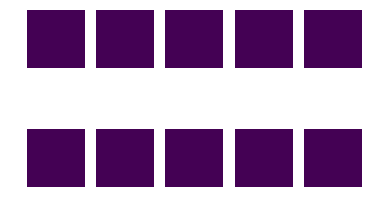

i 99, D_loss 17.148088455200195, G_loss 0.39448681473731995


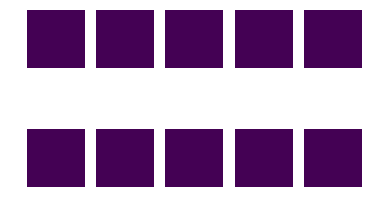

i 199, D_loss 16.545976638793945, G_loss 0.38169002532958984


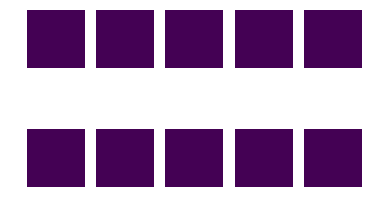

i 299, D_loss 15.2398042678833, G_loss 0.38072481751441956


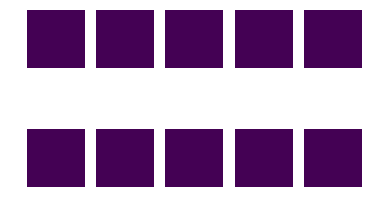

i 399, D_loss 14.20578384399414, G_loss 0.37957391142845154


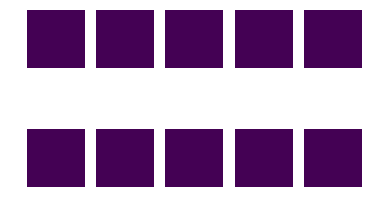

i 499, D_loss 13.817251205444336, G_loss 0.3786866366863251


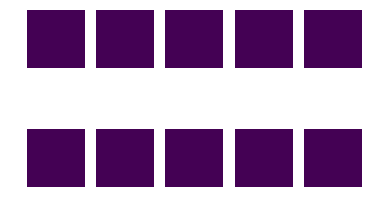

i 599, D_loss 13.640664100646973, G_loss 0.37862449884414673


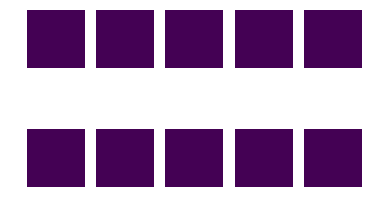

i 699, D_loss 13.515401840209961, G_loss 0.3786044120788574


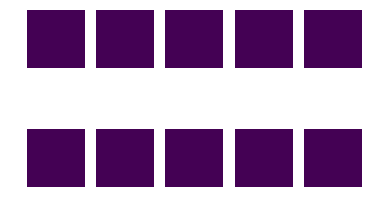

i 799, D_loss 13.421422004699707, G_loss 0.3786643147468567


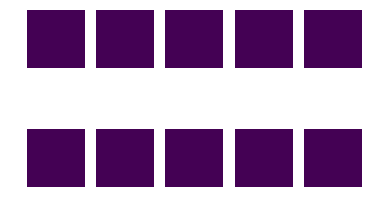

i 899, D_loss 13.353548049926758, G_loss 0.37876906991004944


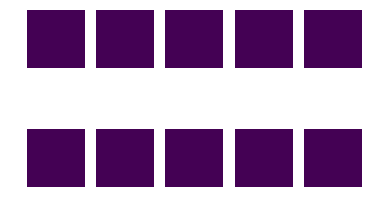

i 999, D_loss 13.307902336120605, G_loss 0.37889930605888367


In [18]:
for i in range(1000):
    X_batch, _ = mnist.train.next_batch(batch_size)
    _, D_loss_curr = sess.run([D_optimizer, D_loss], feed_dict={X: X_batch, Z: sample_Z(batch_size, in_dim)})
    _, G_loss_curr = sess.run([G_optimizer, G_loss], feed_dict={Z: sample_Z(batch_size, in_dim)})
    if (i+1) % 100 == 0:
        G_display = sess.run(G_sample, feed_dict={Z: sample_Z(10, in_dim)})
        plot(G_display)
        print('i {}, D_loss {}, G_loss {}'.format(i, D_loss_curr, G_loss_curr))

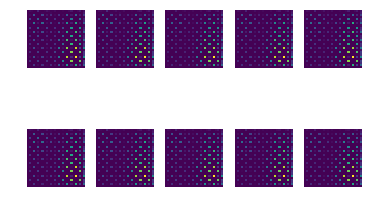

i 0, D_loss 0.0, G_loss 0.0


In [15]:
sess.run(tf.global_variables_initializer())
point = 100

for i in range(10):
    for j in range(0, 200):
        if j < 100:
            X_batch, _ = mnist.train.next_batch(batch_size)
            _, D_loss_curr = sess.run([D_optimizer, D_loss], feed_dict={X: X_batch, Z: sample_Z(batch_size, in_dim)})
        else:
            _, G_loss_curr = sess.run([G_optimizer, G_loss], feed_dict={Z: sample_Z(batch_size, in_dim)})
    if i % 100 == 0:
        G_display = sess.run(G_sample, feed_dict={Z: sample_Z(10, in_dim)})
        plot(G_display)
        print('i {}, D_loss {}, G_loss {}'.format(i, D_loss_curr, G_loss_curr))